# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

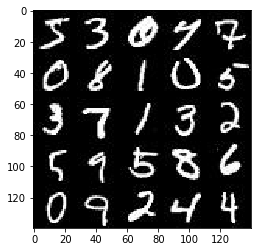

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

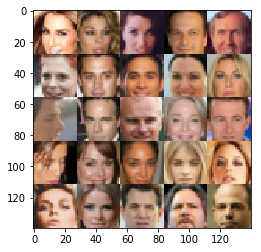

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/seth.bunke/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    input_learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, input_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha=0.2
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    with  tf.variable_scope("generator",reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        l1 = tf.reshape(l1, (-1, 7, 7, 128))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(0.2 * l1, l1)
        # 7x7x128 now
        l2 = tf.layers.conv2d_transpose(l1, 64, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(0.2 * l2, l2)
        # 14x14x64 now
        # Output layer
        logits = tf.layers.conv2d_transpose(l2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
    return out
    
#     with tf.variable_scope('generator', reuse=not is_train):
        
#         alpha = 0.02
        
#         # First fully connected layer
#         x1 = tf.layers.dense(z, 4*4*512)
#         # Reshape it to start the convolutional stack
#         x1 = tf.reshape(x1, (-1, 4, 4, 512))
#         x1 = tf.layers.batch_normalization(x1, training=is_train)
#         x1 = tf.maximum(alpha * x1, x1)
#         # 4x4x512 now
        
#         x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum(alpha * x2, x2)
#         # 8x8x256 now
        
#         x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(alpha * x3, x3)
#         # 16x16x128 now
        
#         # Output layer
#         logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
#         # 32x32x3 now
        
#         out = tf.tanh(logits)
#     with tf.variable_scope('generator', reuse= not is_train):
#         h1 = tf.contrib.layers.fully_connected(z, 128, activation_fn=None)
#         h1 = tf.maximum(0.01 * h1, h1)
        
#         logits = tf.contrib.layers.fully_connected(h1, 784)
#         out = tf.tanh(logits)
#         out = tf.reshape(out, [-1, 28, 28, out_channel_dim])

#         return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim) 
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) 

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0

    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                # Get images, reshape and rescale to pass to D
                #batch_images = batch_images.reshape((batch_size, 784))
                batch_images = batch_images*2

                #Step 1. Random Noise to feed into G
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))

                #Step 2. Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    #train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

#                 if steps % show_every == 0:
#                     gen_samples = sess.run(
#                                    generator(input_z, 3, is_train=False),
#                                    feed_dict={input_z: sample_z})
#                     samples.append(gen_samples)
#                     _ = view_samples(-1, samples, 6, 12, figsize=figsize)
#                     plt.show()
                    
#         saver.save(sess, './checkpoints/generator.ckpt')
        
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)

#     return losses, samples           
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.1020... Generator Loss: 2.7099
Epoch 0/2... Discriminator Loss: 0.1347... Generator Loss: 2.6661
Epoch 0/2... Discriminator Loss: 1.2534... Generator Loss: 0.5671
Epoch 0/2... Discriminator Loss: 0.2866... Generator Loss: 5.3752
Epoch 0/2... Discriminator Loss: 0.6337... Generator Loss: 5.0147
Epoch 0/2... Discriminator Loss: 0.1703... Generator Loss: 3.5381
Epoch 0/2... Discriminator Loss: 0.1620... Generator Loss: 2.8920
Epoch 0/2... Discriminator Loss: 0.7089... Generator Loss: 1.5967
Epoch 0/2... Discriminator Loss: 0.1864... Generator Loss: 3.5141
Epoch 0/2... Discriminator Loss: 0.1843... Generator Loss: 2.7579


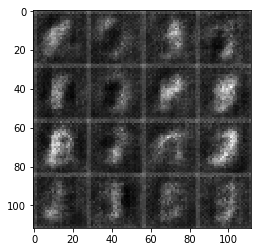

Epoch 0/2... Discriminator Loss: 0.2000... Generator Loss: 3.1105
Epoch 0/2... Discriminator Loss: 0.8641... Generator Loss: 5.5034
Epoch 0/2... Discriminator Loss: 0.3042... Generator Loss: 2.0897
Epoch 0/2... Discriminator Loss: 0.3880... Generator Loss: 3.4709
Epoch 0/2... Discriminator Loss: 0.5576... Generator Loss: 1.2812
Epoch 0/2... Discriminator Loss: 0.3665... Generator Loss: 1.6433
Epoch 0/2... Discriminator Loss: 0.6747... Generator Loss: 0.8965
Epoch 0/2... Discriminator Loss: 0.2825... Generator Loss: 2.2030
Epoch 0/2... Discriminator Loss: 0.4725... Generator Loss: 1.3980
Epoch 0/2... Discriminator Loss: 0.3469... Generator Loss: 2.0383


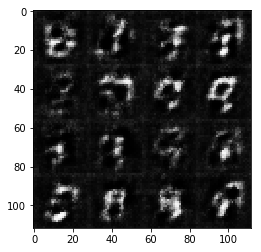

Epoch 0/2... Discriminator Loss: 0.8748... Generator Loss: 1.2401
Epoch 0/2... Discriminator Loss: 0.3258... Generator Loss: 2.4430
Epoch 0/2... Discriminator Loss: 0.2379... Generator Loss: 2.3584
Epoch 0/2... Discriminator Loss: 0.4964... Generator Loss: 1.2337
Epoch 0/2... Discriminator Loss: 0.4017... Generator Loss: 2.5990
Epoch 0/2... Discriminator Loss: 0.1936... Generator Loss: 2.7429
Epoch 0/2... Discriminator Loss: 0.3700... Generator Loss: 2.8712
Epoch 0/2... Discriminator Loss: 0.6636... Generator Loss: 1.1536
Epoch 0/2... Discriminator Loss: 0.4706... Generator Loss: 1.2667
Epoch 0/2... Discriminator Loss: 1.5448... Generator Loss: 0.3215


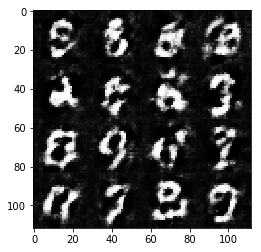

Epoch 0/2... Discriminator Loss: 0.2951... Generator Loss: 2.2226
Epoch 0/2... Discriminator Loss: 0.2781... Generator Loss: 2.1044
Epoch 0/2... Discriminator Loss: 0.3986... Generator Loss: 2.0298
Epoch 0/2... Discriminator Loss: 0.3519... Generator Loss: 1.9875
Epoch 0/2... Discriminator Loss: 0.2168... Generator Loss: 2.1241
Epoch 0/2... Discriminator Loss: 0.3103... Generator Loss: 2.0339
Epoch 0/2... Discriminator Loss: 0.4146... Generator Loss: 1.4520
Epoch 0/2... Discriminator Loss: 0.6638... Generator Loss: 0.9706
Epoch 0/2... Discriminator Loss: 0.1577... Generator Loss: 2.6425
Epoch 0/2... Discriminator Loss: 0.3718... Generator Loss: 1.5489


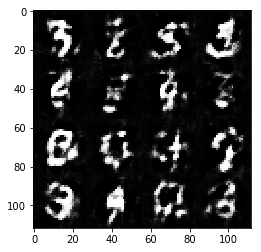

Epoch 0/2... Discriminator Loss: 1.9457... Generator Loss: 0.2254
Epoch 0/2... Discriminator Loss: 0.2189... Generator Loss: 2.5739
Epoch 0/2... Discriminator Loss: 0.3691... Generator Loss: 1.8201
Epoch 0/2... Discriminator Loss: 0.6521... Generator Loss: 0.9608
Epoch 0/2... Discriminator Loss: 0.2208... Generator Loss: 2.3116
Epoch 0/2... Discriminator Loss: 0.5844... Generator Loss: 1.0282
Epoch 0/2... Discriminator Loss: 0.2933... Generator Loss: 1.7934
Epoch 0/2... Discriminator Loss: 0.2975... Generator Loss: 2.6116
Epoch 0/2... Discriminator Loss: 0.2777... Generator Loss: 2.6714
Epoch 0/2... Discriminator Loss: 0.2421... Generator Loss: 2.6509


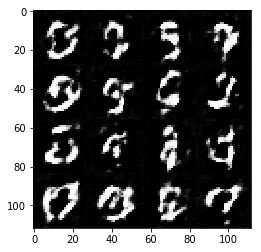

Epoch 0/2... Discriminator Loss: 0.3250... Generator Loss: 1.7375
Epoch 0/2... Discriminator Loss: 0.2349... Generator Loss: 2.5434
Epoch 0/2... Discriminator Loss: 0.3167... Generator Loss: 1.6991
Epoch 0/2... Discriminator Loss: 0.2167... Generator Loss: 2.6443
Epoch 0/2... Discriminator Loss: 0.3550... Generator Loss: 3.8767
Epoch 0/2... Discriminator Loss: 3.0450... Generator Loss: 8.1984
Epoch 0/2... Discriminator Loss: 0.2994... Generator Loss: 2.7606
Epoch 0/2... Discriminator Loss: 0.2311... Generator Loss: 2.1096
Epoch 0/2... Discriminator Loss: 0.2886... Generator Loss: 2.0869
Epoch 0/2... Discriminator Loss: 0.1976... Generator Loss: 2.4382


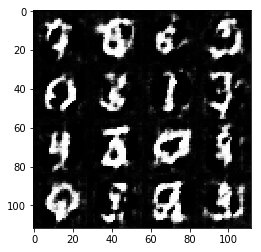

Epoch 0/2... Discriminator Loss: 0.2291... Generator Loss: 2.1978
Epoch 0/2... Discriminator Loss: 0.2539... Generator Loss: 2.0167
Epoch 0/2... Discriminator Loss: 0.3562... Generator Loss: 1.6567
Epoch 0/2... Discriminator Loss: 0.1926... Generator Loss: 3.1514
Epoch 0/2... Discriminator Loss: 0.3019... Generator Loss: 1.9059
Epoch 0/2... Discriminator Loss: 0.1450... Generator Loss: 2.6898
Epoch 0/2... Discriminator Loss: 0.2844... Generator Loss: 1.8701
Epoch 0/2... Discriminator Loss: 0.2842... Generator Loss: 2.3749
Epoch 0/2... Discriminator Loss: 0.3029... Generator Loss: 1.7910
Epoch 0/2... Discriminator Loss: 0.2635... Generator Loss: 2.2195


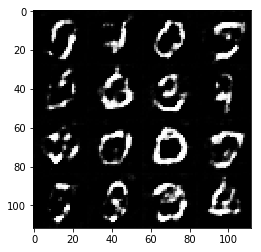

Epoch 0/2... Discriminator Loss: 0.2291... Generator Loss: 2.2212
Epoch 0/2... Discriminator Loss: 0.5095... Generator Loss: 1.4175
Epoch 0/2... Discriminator Loss: 0.2008... Generator Loss: 3.7301
Epoch 0/2... Discriminator Loss: 0.1747... Generator Loss: 2.6676
Epoch 0/2... Discriminator Loss: 0.1998... Generator Loss: 3.3239
Epoch 0/2... Discriminator Loss: 0.1541... Generator Loss: 2.4688
Epoch 0/2... Discriminator Loss: 0.2631... Generator Loss: 3.1309
Epoch 0/2... Discriminator Loss: 0.4560... Generator Loss: 1.4837
Epoch 0/2... Discriminator Loss: 0.2664... Generator Loss: 2.1738
Epoch 0/2... Discriminator Loss: 1.2486... Generator Loss: 0.4606


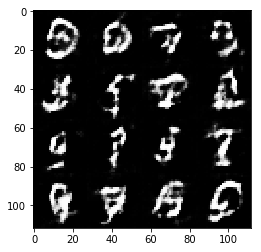

Epoch 0/2... Discriminator Loss: 0.2358... Generator Loss: 2.1736
Epoch 0/2... Discriminator Loss: 0.3360... Generator Loss: 1.8504
Epoch 0/2... Discriminator Loss: 0.3894... Generator Loss: 3.1576
Epoch 0/2... Discriminator Loss: 0.2673... Generator Loss: 1.9770
Epoch 0/2... Discriminator Loss: 0.2109... Generator Loss: 2.9602
Epoch 0/2... Discriminator Loss: 0.2243... Generator Loss: 3.3434
Epoch 0/2... Discriminator Loss: 0.6990... Generator Loss: 0.9617
Epoch 0/2... Discriminator Loss: 0.8135... Generator Loss: 0.7850
Epoch 0/2... Discriminator Loss: 0.8447... Generator Loss: 0.8224
Epoch 0/2... Discriminator Loss: 0.1623... Generator Loss: 2.5368


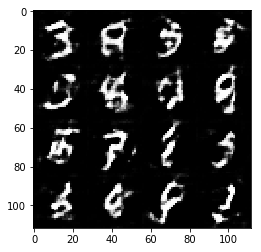

Epoch 0/2... Discriminator Loss: 0.3433... Generator Loss: 3.5973
Epoch 0/2... Discriminator Loss: 0.2645... Generator Loss: 2.4917
Epoch 0/2... Discriminator Loss: 0.8235... Generator Loss: 0.8807
Epoch 0/2... Discriminator Loss: 0.4154... Generator Loss: 1.5642
Epoch 0/2... Discriminator Loss: 0.3921... Generator Loss: 1.8250
Epoch 0/2... Discriminator Loss: 0.2847... Generator Loss: 2.0700
Epoch 0/2... Discriminator Loss: 0.4745... Generator Loss: 2.3134
Epoch 0/2... Discriminator Loss: 0.1476... Generator Loss: 3.2027
Epoch 0/2... Discriminator Loss: 0.2048... Generator Loss: 2.4723
Epoch 0/2... Discriminator Loss: 0.3927... Generator Loss: 1.5796


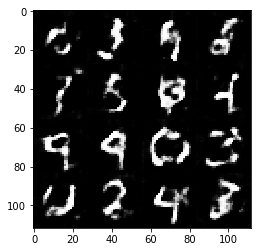

Epoch 0/2... Discriminator Loss: 0.5303... Generator Loss: 1.2201
Epoch 0/2... Discriminator Loss: 0.4651... Generator Loss: 1.4268
Epoch 0/2... Discriminator Loss: 0.2494... Generator Loss: 2.3307
Epoch 0/2... Discriminator Loss: 0.5093... Generator Loss: 1.2109
Epoch 0/2... Discriminator Loss: 0.3924... Generator Loss: 1.4853
Epoch 0/2... Discriminator Loss: 0.2507... Generator Loss: 2.2463
Epoch 0/2... Discriminator Loss: 0.2574... Generator Loss: 1.7368
Epoch 0/2... Discriminator Loss: 0.2145... Generator Loss: 2.2401
Epoch 0/2... Discriminator Loss: 0.3876... Generator Loss: 2.3531
Epoch 0/2... Discriminator Loss: 0.3922... Generator Loss: 1.4935


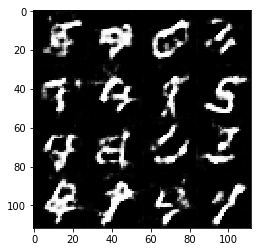

Epoch 0/2... Discriminator Loss: 1.7122... Generator Loss: 0.3521
Epoch 0/2... Discriminator Loss: 0.3432... Generator Loss: 2.1064
Epoch 0/2... Discriminator Loss: 0.1582... Generator Loss: 2.6855
Epoch 0/2... Discriminator Loss: 0.3289... Generator Loss: 1.6719
Epoch 0/2... Discriminator Loss: 1.0906... Generator Loss: 5.0405
Epoch 0/2... Discriminator Loss: 0.3047... Generator Loss: 2.0264
Epoch 0/2... Discriminator Loss: 0.3355... Generator Loss: 1.8604
Epoch 0/2... Discriminator Loss: 0.1704... Generator Loss: 3.1686
Epoch 0/2... Discriminator Loss: 0.2411... Generator Loss: 2.4091
Epoch 0/2... Discriminator Loss: 0.2820... Generator Loss: 2.8290


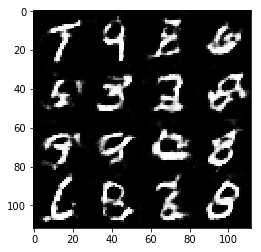

Epoch 0/2... Discriminator Loss: 0.3905... Generator Loss: 1.7656
Epoch 0/2... Discriminator Loss: 0.2982... Generator Loss: 2.0609
Epoch 0/2... Discriminator Loss: 0.3523... Generator Loss: 1.7280
Epoch 0/2... Discriminator Loss: 0.4596... Generator Loss: 1.4035
Epoch 0/2... Discriminator Loss: 0.2266... Generator Loss: 2.3335
Epoch 0/2... Discriminator Loss: 0.2595... Generator Loss: 2.0941
Epoch 0/2... Discriminator Loss: 0.5581... Generator Loss: 1.3867
Epoch 0/2... Discriminator Loss: 0.1498... Generator Loss: 3.4536
Epoch 0/2... Discriminator Loss: 0.2679... Generator Loss: 2.0362
Epoch 0/2... Discriminator Loss: 1.3893... Generator Loss: 0.4995


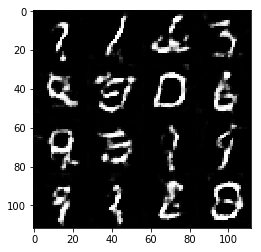

Epoch 0/2... Discriminator Loss: 0.2518... Generator Loss: 3.3375
Epoch 0/2... Discriminator Loss: 0.3002... Generator Loss: 1.9513
Epoch 0/2... Discriminator Loss: 0.5172... Generator Loss: 1.1964
Epoch 0/2... Discriminator Loss: 0.2881... Generator Loss: 1.8383
Epoch 0/2... Discriminator Loss: 1.5328... Generator Loss: 0.4557
Epoch 0/2... Discriminator Loss: 0.5725... Generator Loss: 1.2402
Epoch 0/2... Discriminator Loss: 0.3283... Generator Loss: 1.8670
Epoch 0/2... Discriminator Loss: 0.2460... Generator Loss: 1.9960
Epoch 0/2... Discriminator Loss: 0.3724... Generator Loss: 1.6086
Epoch 0/2... Discriminator Loss: 0.6107... Generator Loss: 1.0798


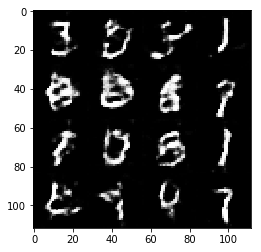

Epoch 0/2... Discriminator Loss: 0.2980... Generator Loss: 1.8667
Epoch 0/2... Discriminator Loss: 0.3535... Generator Loss: 2.8373
Epoch 0/2... Discriminator Loss: 0.7493... Generator Loss: 5.0470
Epoch 0/2... Discriminator Loss: 0.3782... Generator Loss: 1.6569
Epoch 0/2... Discriminator Loss: 0.2220... Generator Loss: 2.2475
Epoch 0/2... Discriminator Loss: 0.3407... Generator Loss: 1.8012
Epoch 0/2... Discriminator Loss: 0.3334... Generator Loss: 1.7636
Epoch 0/2... Discriminator Loss: 0.2118... Generator Loss: 2.3823
Epoch 0/2... Discriminator Loss: 0.5116... Generator Loss: 1.2617
Epoch 0/2... Discriminator Loss: 0.1606... Generator Loss: 2.8415


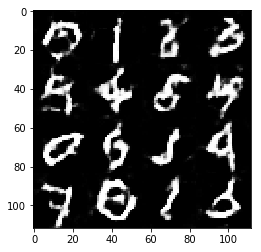

Epoch 0/2... Discriminator Loss: 0.4361... Generator Loss: 1.3382
Epoch 0/2... Discriminator Loss: 0.2461... Generator Loss: 2.1532
Epoch 0/2... Discriminator Loss: 0.3012... Generator Loss: 2.1647
Epoch 0/2... Discriminator Loss: 0.2017... Generator Loss: 2.1334
Epoch 0/2... Discriminator Loss: 0.7428... Generator Loss: 0.9535
Epoch 0/2... Discriminator Loss: 1.7076... Generator Loss: 0.4526
Epoch 0/2... Discriminator Loss: 0.4403... Generator Loss: 3.0666
Epoch 0/2... Discriminator Loss: 0.3705... Generator Loss: 1.9675
Epoch 0/2... Discriminator Loss: 0.4525... Generator Loss: 1.4304
Epoch 0/2... Discriminator Loss: 0.3283... Generator Loss: 1.6345


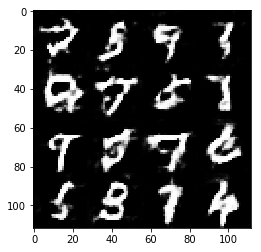

Epoch 0/2... Discriminator Loss: 0.2989... Generator Loss: 1.9714
Epoch 0/2... Discriminator Loss: 0.2478... Generator Loss: 2.5320
Epoch 0/2... Discriminator Loss: 0.2892... Generator Loss: 1.8977
Epoch 0/2... Discriminator Loss: 0.2969... Generator Loss: 1.7782
Epoch 0/2... Discriminator Loss: 0.2097... Generator Loss: 2.5766
Epoch 0/2... Discriminator Loss: 0.1771... Generator Loss: 2.6457
Epoch 0/2... Discriminator Loss: 0.5007... Generator Loss: 1.2544
Epoch 0/2... Discriminator Loss: 0.1677... Generator Loss: 2.5272
Epoch 0/2... Discriminator Loss: 0.2643... Generator Loss: 1.8077
Epoch 0/2... Discriminator Loss: 0.2731... Generator Loss: 2.1236


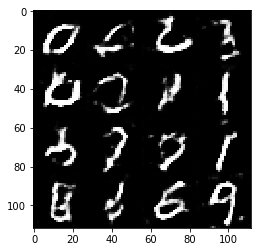

Epoch 0/2... Discriminator Loss: 0.1928... Generator Loss: 2.5534
Epoch 0/2... Discriminator Loss: 0.9205... Generator Loss: 2.2260
Epoch 0/2... Discriminator Loss: 1.3533... Generator Loss: 0.6083
Epoch 0/2... Discriminator Loss: 0.4324... Generator Loss: 2.0030
Epoch 0/2... Discriminator Loss: 0.3454... Generator Loss: 1.8177
Epoch 0/2... Discriminator Loss: 0.2665... Generator Loss: 2.3086
Epoch 0/2... Discriminator Loss: 0.2038... Generator Loss: 2.2538
Epoch 0/2... Discriminator Loss: 0.2466... Generator Loss: 2.2354
Epoch 0/2... Discriminator Loss: 0.1513... Generator Loss: 3.3707
Epoch 0/2... Discriminator Loss: 0.2103... Generator Loss: 2.1174


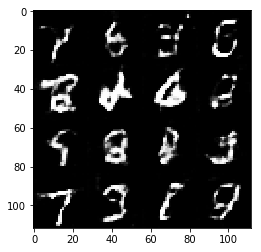

Epoch 0/2... Discriminator Loss: 0.3445... Generator Loss: 1.5772
Epoch 0/2... Discriminator Loss: 0.2265... Generator Loss: 2.2293
Epoch 0/2... Discriminator Loss: 0.4360... Generator Loss: 1.4543
Epoch 0/2... Discriminator Loss: 0.1496... Generator Loss: 2.6499
Epoch 0/2... Discriminator Loss: 0.2836... Generator Loss: 1.8102
Epoch 0/2... Discriminator Loss: 0.3497... Generator Loss: 1.5828
Epoch 0/2... Discriminator Loss: 0.1572... Generator Loss: 2.3671
Epoch 1/2... Discriminator Loss: 0.3069... Generator Loss: 1.8445
Epoch 1/2... Discriminator Loss: 0.2804... Generator Loss: 1.7801
Epoch 1/2... Discriminator Loss: 0.1824... Generator Loss: 2.4217


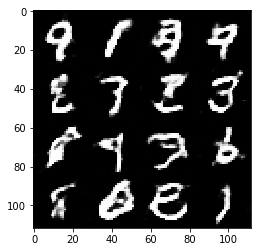

Epoch 1/2... Discriminator Loss: 0.5716... Generator Loss: 3.4851
Epoch 1/2... Discriminator Loss: 0.1891... Generator Loss: 2.3506
Epoch 1/2... Discriminator Loss: 0.3331... Generator Loss: 1.9111
Epoch 1/2... Discriminator Loss: 0.1954... Generator Loss: 2.2157
Epoch 1/2... Discriminator Loss: 0.2035... Generator Loss: 2.3714
Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 1.7516
Epoch 1/2... Discriminator Loss: 0.4292... Generator Loss: 1.4446
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 2.5237
Epoch 1/2... Discriminator Loss: 0.3925... Generator Loss: 2.2009


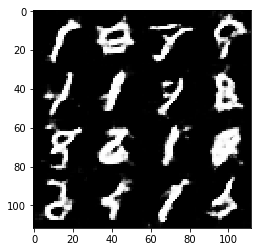

Epoch 1/2... Discriminator Loss: 0.3160... Generator Loss: 2.8951
Epoch 1/2... Discriminator Loss: 0.3948... Generator Loss: 1.5897
Epoch 1/2... Discriminator Loss: 0.3412... Generator Loss: 1.8827
Epoch 1/2... Discriminator Loss: 0.2386... Generator Loss: 2.1496
Epoch 1/2... Discriminator Loss: 0.3702... Generator Loss: 1.6164
Epoch 1/2... Discriminator Loss: 0.2855... Generator Loss: 1.9405
Epoch 1/2... Discriminator Loss: 0.4912... Generator Loss: 1.3583
Epoch 1/2... Discriminator Loss: 0.3047... Generator Loss: 1.8183
Epoch 1/2... Discriminator Loss: 0.2314... Generator Loss: 2.2254
Epoch 1/2... Discriminator Loss: 0.2024... Generator Loss: 2.2347


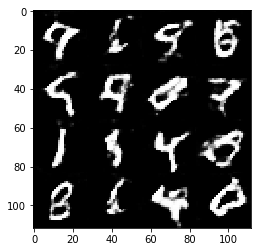

Epoch 1/2... Discriminator Loss: 0.3107... Generator Loss: 1.7303
Epoch 1/2... Discriminator Loss: 0.4687... Generator Loss: 1.2615
Epoch 1/2... Discriminator Loss: 0.1612... Generator Loss: 2.2920
Epoch 1/2... Discriminator Loss: 0.2523... Generator Loss: 2.0740
Epoch 1/2... Discriminator Loss: 0.2560... Generator Loss: 2.1096
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 1.3186
Epoch 1/2... Discriminator Loss: 0.3574... Generator Loss: 1.8008
Epoch 1/2... Discriminator Loss: 0.2338... Generator Loss: 2.2286
Epoch 1/2... Discriminator Loss: 0.1822... Generator Loss: 2.2134
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 1.2680


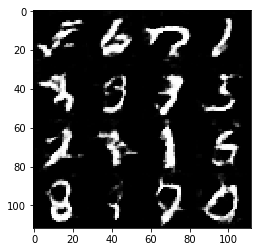

Epoch 1/2... Discriminator Loss: 0.2288... Generator Loss: 3.1926
Epoch 1/2... Discriminator Loss: 0.1564... Generator Loss: 2.3555
Epoch 1/2... Discriminator Loss: 0.2397... Generator Loss: 2.1607
Epoch 1/2... Discriminator Loss: 0.1045... Generator Loss: 2.8881
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 1.3272
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 2.6569
Epoch 1/2... Discriminator Loss: 0.3017... Generator Loss: 1.8775
Epoch 1/2... Discriminator Loss: 0.2194... Generator Loss: 2.0645
Epoch 1/2... Discriminator Loss: 0.1823... Generator Loss: 3.9275
Epoch 1/2... Discriminator Loss: 0.1780... Generator Loss: 2.1643


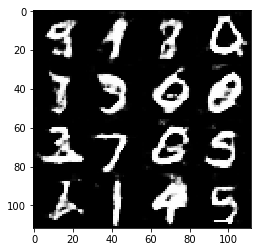

Epoch 1/2... Discriminator Loss: 0.4647... Generator Loss: 1.4162
Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 0.3054... Generator Loss: 2.0996
Epoch 1/2... Discriminator Loss: 0.3831... Generator Loss: 1.9122
Epoch 1/2... Discriminator Loss: 0.1605... Generator Loss: 3.1167
Epoch 1/2... Discriminator Loss: 0.2534... Generator Loss: 2.1348
Epoch 1/2... Discriminator Loss: 0.4330... Generator Loss: 1.5004
Epoch 1/2... Discriminator Loss: 0.4445... Generator Loss: 1.2419
Epoch 1/2... Discriminator Loss: 0.2111... Generator Loss: 2.2295
Epoch 1/2... Discriminator Loss: 0.1200... Generator Loss: 2.6797


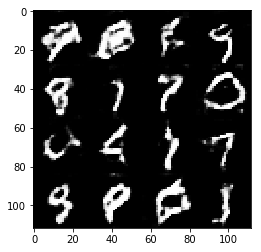

Epoch 1/2... Discriminator Loss: 0.2481... Generator Loss: 1.8820
Epoch 1/2... Discriminator Loss: 0.2685... Generator Loss: 2.9296
Epoch 1/2... Discriminator Loss: 0.2228... Generator Loss: 2.0032
Epoch 1/2... Discriminator Loss: 0.3290... Generator Loss: 1.5958
Epoch 1/2... Discriminator Loss: 0.3047... Generator Loss: 3.7823
Epoch 1/2... Discriminator Loss: 0.1296... Generator Loss: 3.0198
Epoch 1/2... Discriminator Loss: 0.2619... Generator Loss: 1.9470
Epoch 1/2... Discriminator Loss: 0.1686... Generator Loss: 2.4913
Epoch 1/2... Discriminator Loss: 0.1629... Generator Loss: 2.4741
Epoch 1/2... Discriminator Loss: 0.2780... Generator Loss: 1.7764


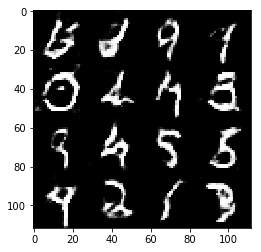

Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 1.3028
Epoch 1/2... Discriminator Loss: 0.2359... Generator Loss: 2.3411
Epoch 1/2... Discriminator Loss: 0.1551... Generator Loss: 2.8298
Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 0.4789... Generator Loss: 1.9754
Epoch 1/2... Discriminator Loss: 0.5495... Generator Loss: 1.3289
Epoch 1/2... Discriminator Loss: 0.4771... Generator Loss: 1.4145
Epoch 1/2... Discriminator Loss: 0.5692... Generator Loss: 3.9124
Epoch 1/2... Discriminator Loss: 0.2604... Generator Loss: 2.8454
Epoch 1/2... Discriminator Loss: 0.3272... Generator Loss: 1.8957


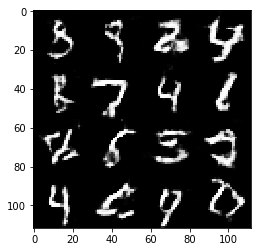

Epoch 1/2... Discriminator Loss: 0.2778... Generator Loss: 2.0658
Epoch 1/2... Discriminator Loss: 0.1543... Generator Loss: 2.3437
Epoch 1/2... Discriminator Loss: 0.2323... Generator Loss: 1.9290
Epoch 1/2... Discriminator Loss: 0.3681... Generator Loss: 1.5691
Epoch 1/2... Discriminator Loss: 0.2673... Generator Loss: 1.8647
Epoch 1/2... Discriminator Loss: 0.2104... Generator Loss: 2.3688
Epoch 1/2... Discriminator Loss: 0.3658... Generator Loss: 1.6155
Epoch 1/2... Discriminator Loss: 0.2527... Generator Loss: 1.7711
Epoch 1/2... Discriminator Loss: 0.1067... Generator Loss: 2.9156
Epoch 1/2... Discriminator Loss: 0.1711... Generator Loss: 2.6831


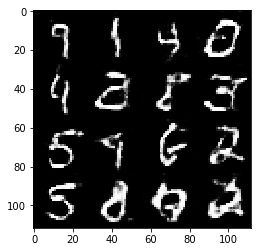

Epoch 1/2... Discriminator Loss: 0.1165... Generator Loss: 2.6329
Epoch 1/2... Discriminator Loss: 0.1830... Generator Loss: 2.2942
Epoch 1/2... Discriminator Loss: 0.5262... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 0.2735... Generator Loss: 1.8723
Epoch 1/2... Discriminator Loss: 0.2380... Generator Loss: 1.9834
Epoch 1/2... Discriminator Loss: 0.1423... Generator Loss: 2.6210
Epoch 1/2... Discriminator Loss: 0.1147... Generator Loss: 2.7707
Epoch 1/2... Discriminator Loss: 0.2331... Generator Loss: 1.9848
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.4200
Epoch 1/2... Discriminator Loss: 0.1620... Generator Loss: 2.7025


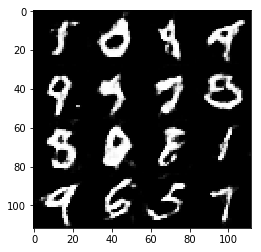

Epoch 1/2... Discriminator Loss: 0.2096... Generator Loss: 2.2248
Epoch 1/2... Discriminator Loss: 0.3215... Generator Loss: 1.7587
Epoch 1/2... Discriminator Loss: 0.2973... Generator Loss: 1.7311
Epoch 1/2... Discriminator Loss: 0.5529... Generator Loss: 1.4532
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 0.4685
Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 0.2531... Generator Loss: 1.8661
Epoch 1/2... Discriminator Loss: 0.2377... Generator Loss: 1.9922
Epoch 1/2... Discriminator Loss: 0.2120... Generator Loss: 2.2300
Epoch 1/2... Discriminator Loss: 0.6024... Generator Loss: 1.1120


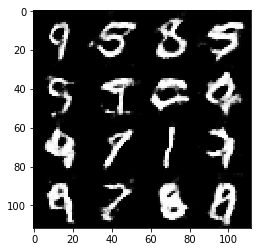

Epoch 1/2... Discriminator Loss: 0.2971... Generator Loss: 1.6582
Epoch 1/2... Discriminator Loss: 0.2484... Generator Loss: 1.9628
Epoch 1/2... Discriminator Loss: 0.2152... Generator Loss: 2.2801
Epoch 1/2... Discriminator Loss: 0.3381... Generator Loss: 1.5298
Epoch 1/2... Discriminator Loss: 0.1966... Generator Loss: 2.1434
Epoch 1/2... Discriminator Loss: 0.2372... Generator Loss: 2.1412
Epoch 1/2... Discriminator Loss: 0.4122... Generator Loss: 1.3348
Epoch 1/2... Discriminator Loss: 0.2063... Generator Loss: 2.4720
Epoch 1/2... Discriminator Loss: 0.1847... Generator Loss: 2.3219
Epoch 1/2... Discriminator Loss: 0.4200... Generator Loss: 2.2718


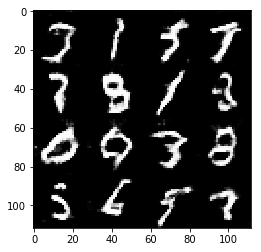

Epoch 1/2... Discriminator Loss: 5.2967... Generator Loss: 0.0928
Epoch 1/2... Discriminator Loss: 0.7430... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 0.5206... Generator Loss: 1.6604
Epoch 1/2... Discriminator Loss: 0.4742... Generator Loss: 1.7754
Epoch 1/2... Discriminator Loss: 0.3282... Generator Loss: 2.0326
Epoch 1/2... Discriminator Loss: 0.2252... Generator Loss: 3.1088
Epoch 1/2... Discriminator Loss: 0.3317... Generator Loss: 1.7669
Epoch 1/2... Discriminator Loss: 0.2820... Generator Loss: 2.0322
Epoch 1/2... Discriminator Loss: 0.3077... Generator Loss: 2.0230
Epoch 1/2... Discriminator Loss: 0.1437... Generator Loss: 3.0414


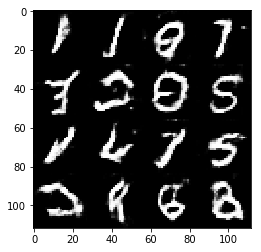

Epoch 1/2... Discriminator Loss: 0.2658... Generator Loss: 1.8520
Epoch 1/2... Discriminator Loss: 0.1520... Generator Loss: 3.1221
Epoch 1/2... Discriminator Loss: 0.3979... Generator Loss: 1.5836
Epoch 1/2... Discriminator Loss: 0.3322... Generator Loss: 1.7265
Epoch 1/2... Discriminator Loss: 0.2355... Generator Loss: 2.0602
Epoch 1/2... Discriminator Loss: 0.2654... Generator Loss: 1.7865
Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 1.5942
Epoch 1/2... Discriminator Loss: 0.3835... Generator Loss: 1.4577
Epoch 1/2... Discriminator Loss: 0.3884... Generator Loss: 1.3933
Epoch 1/2... Discriminator Loss: 0.2289... Generator Loss: 2.1054


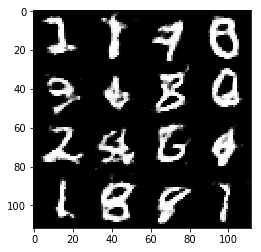

Epoch 1/2... Discriminator Loss: 0.2337... Generator Loss: 2.0278
Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 1.5547
Epoch 1/2... Discriminator Loss: 0.2683... Generator Loss: 3.7434
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 1.5849
Epoch 1/2... Discriminator Loss: 0.2454... Generator Loss: 2.2109
Epoch 1/2... Discriminator Loss: 0.3554... Generator Loss: 1.6529
Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 1.3645
Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 0.1166... Generator Loss: 2.8805


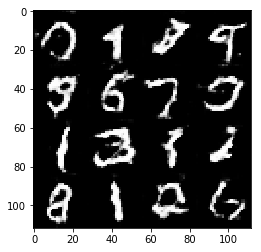

Epoch 1/2... Discriminator Loss: 0.2382... Generator Loss: 1.9068
Epoch 1/2... Discriminator Loss: 0.2102... Generator Loss: 2.0296
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 1.0617
Epoch 1/2... Discriminator Loss: 0.1292... Generator Loss: 2.8240
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 0.3697... Generator Loss: 1.5273
Epoch 1/2... Discriminator Loss: 0.1735... Generator Loss: 2.5898
Epoch 1/2... Discriminator Loss: 0.1543... Generator Loss: 2.3892
Epoch 1/2... Discriminator Loss: 0.2142... Generator Loss: 2.3635
Epoch 1/2... Discriminator Loss: 0.5497... Generator Loss: 1.1688


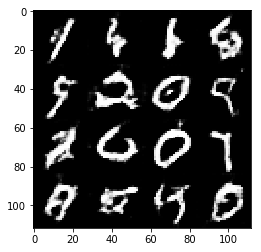

Epoch 1/2... Discriminator Loss: 0.2013... Generator Loss: 2.2126
Epoch 1/2... Discriminator Loss: 0.2196... Generator Loss: 2.5757
Epoch 1/2... Discriminator Loss: 0.3804... Generator Loss: 1.5008
Epoch 1/2... Discriminator Loss: 0.1830... Generator Loss: 2.1765
Epoch 1/2... Discriminator Loss: 0.2983... Generator Loss: 1.8536
Epoch 1/2... Discriminator Loss: 0.6464... Generator Loss: 1.1604
Epoch 1/2... Discriminator Loss: 0.3572... Generator Loss: 1.7557
Epoch 1/2... Discriminator Loss: 0.1687... Generator Loss: 2.4604
Epoch 1/2... Discriminator Loss: 0.2780... Generator Loss: 1.6785
Epoch 1/2... Discriminator Loss: 0.2810... Generator Loss: 3.6478


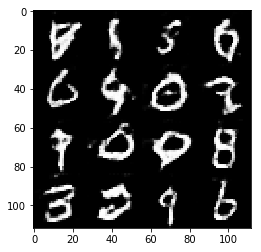

Epoch 1/2... Discriminator Loss: 0.3713... Generator Loss: 3.1946
Epoch 1/2... Discriminator Loss: 0.2297... Generator Loss: 2.6177
Epoch 1/2... Discriminator Loss: 0.3268... Generator Loss: 1.5927
Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 2.3610
Epoch 1/2... Discriminator Loss: 0.2621... Generator Loss: 1.9203
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.0143
Epoch 1/2... Discriminator Loss: 0.9655... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 0.2031... Generator Loss: 2.6893
Epoch 1/2... Discriminator Loss: 0.3237... Generator Loss: 1.7616
Epoch 1/2... Discriminator Loss: 0.2721... Generator Loss: 2.3208


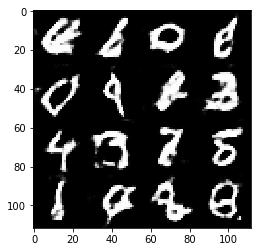

Epoch 1/2... Discriminator Loss: 0.1667... Generator Loss: 3.2091
Epoch 1/2... Discriminator Loss: 0.3989... Generator Loss: 2.0768
Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 2.9120
Epoch 1/2... Discriminator Loss: 0.6787... Generator Loss: 2.6954
Epoch 1/2... Discriminator Loss: 0.4346... Generator Loss: 2.1381
Epoch 1/2... Discriminator Loss: 0.4504... Generator Loss: 1.3623
Epoch 1/2... Discriminator Loss: 0.2642... Generator Loss: 1.9348
Epoch 1/2... Discriminator Loss: 0.4445... Generator Loss: 1.3049
Epoch 1/2... Discriminator Loss: 0.2226... Generator Loss: 2.1495
Epoch 1/2... Discriminator Loss: 0.2377... Generator Loss: 2.4359


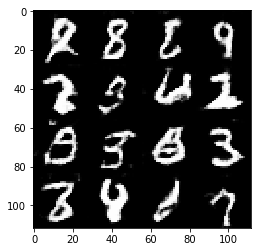

Epoch 1/2... Discriminator Loss: 0.2398... Generator Loss: 2.0887
Epoch 1/2... Discriminator Loss: 0.1820... Generator Loss: 2.3093
Epoch 1/2... Discriminator Loss: 0.3057... Generator Loss: 1.9078
Epoch 1/2... Discriminator Loss: 0.3276... Generator Loss: 1.8282
Epoch 1/2... Discriminator Loss: 0.1135... Generator Loss: 3.3607


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.